In [86]:
import pandas as pd
import numpy as np

data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

### Підготовка даних до початку порівняння методів балансування

In [87]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No":"0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No":"0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


In [88]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


le = LabelEncoder()
data1 = data.copy(deep = True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [89]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(X, y, test_size=0.35, random_state=0)
scaler = StandardScaler()

Одразу розділяємо дані на набори для тренування та тестування. Балансування класів на всій множині даних призводить до витоку даних та перенавчанню моделі (особливо дерева рішень), також це завадить корректні оцінці моделі на початкових даних. Балансування класів буде відбуватись на тренувальному наборі, тестування моделей - на наборі для тестування.

### Функція валідації моделі

Модель випробовується на початкових даних. Працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [90]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, model_scaler, balancing_method_name: str):        
    global all_logreg_logs, all_dtree_logs, X_initial_test, y_initial_test
    
    X_initial_scaled = model_scaler.transform(X_initial_test)
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_scaled, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_scaled)[:, 1]
        y_pred_initial = model.predict(X_initial_scaled)
    
    accuracy_initial = accuracy_score(y_initial_test, y_pred_initial)
    precision_initial = precision_score(y_initial_test, y_pred_initial)
    recall_initial = recall_score(y_initial_test, y_pred_initial)
    f1_initial = f1_score(y_initial_test, y_pred_initial)
    roc_auc_initial = roc_auc_score(y_initial_test, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nDecision Tree")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після тренування кожної моделі виводиться лог точності моделі по **збалансованим даним**. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [91]:
def train_models(X_balanced, y_balanced, balancing_method_name: str):
    global scaler
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.35, random_state=0)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    logreg_model = train_regression_model(X_train_scaled, X_test_scaled, y_train, y_test)
    
    dtree_model = train_dtree_model(X_train_scaled, X_test_scaled, y_train, y_test)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, scaler, balancing_method_name)
    validate_model(dtree_model, scaler, balancing_method_name)

In [92]:
def train_regression_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    y_pred_log = logreg.predict(X_test_balanced)
    
    y_pred_proba_log = logreg.predict_proba(X_test_balanced)
    fpr_log, tpr_log, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_log[:,1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_log),
                             precision_score(y_test_balanced, y_pred_log, average='binary'),
                             recall_score(y_test_balanced, y_pred_log, average='binary'),
                             f1_score(y_test_balanced, y_pred_log, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_log[:,1])],
                       index=['Accuracy','Precision','Recall','F1-score','AUC'],
                       columns=["Logistic Regression"])
    print(log)
    return logreg

In [93]:
def train_dtree_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)
    y_pred_tree = dtree.predict(X_test_balanced)
    
    y_pred_proba_tree = dtree.predict_proba(X_test_balanced)
    fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_tree[:, 1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_tree),
                             precision_score(y_test_balanced, y_pred_tree, average='binary'),
                             recall_score(y_test_balanced, y_pred_tree, average='binary'),
                             f1_score(y_test_balanced, y_pred_tree, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_tree[:, 1])],
                       index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                       columns=["Decision Tree"])
    print(log)
    return dtree

In [94]:
# Показуємо розподіл після методу балансування
def show_stats(y_balanced, balanced_method_name):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=y_balanced, hue=y_balanced, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container, label_type='center', rotation=0, color='white')
    plt.title(f"Розподіл після {balanced_method_name}", size=16)
    plt.show()

### Without Sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти якщо модель після балансування класів буде менш точною.

In [95]:
train_models(X_initial_train, y_initial_train, "Without_Sampling")

           Logistic Regression
Accuracy              0.941487
Precision             0.460132
Recall                0.385342
F1-score              0.419429
AUC                   0.880946
           Decision Tree
Accuracy        0.911756
Precision       0.246542
Recall          0.296091
F1-score        0.269054
AUC             0.621789


Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.942793   0.470887  0.394294    0.4292  0.885052

Decision Tree
                  Accuracy  Precision   Recall  F1-score       AUC
Without_Sampling  0.913121   0.248464  0.29274  0.268791  0.620827


## Oversampling

Усього було випробовано 5 методів: Random Oversampling, SMOTE, ADASYN, K-means SMOTE, BorderLineSMOTE

### Random Oversampling

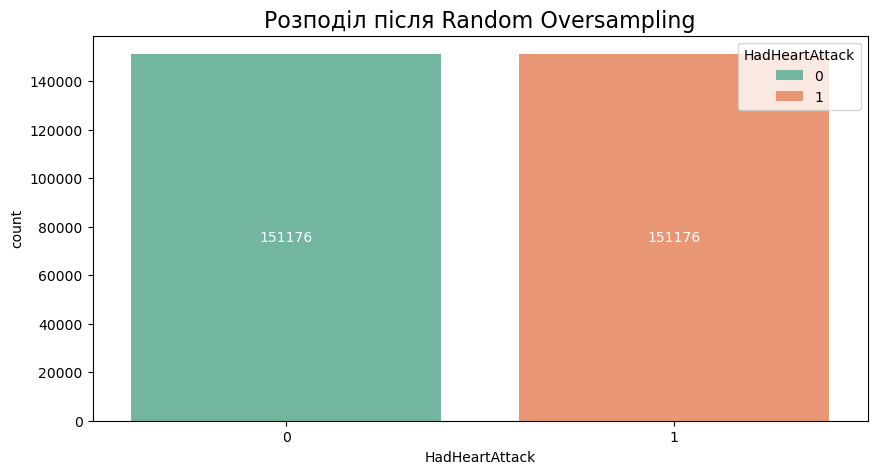

In [96]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_ROS, y_ROS = oversample.fit_resample(X_initial_train, y_initial_train)

show_stats(y_ROS, "Random Oversampling")

In [97]:
train_models(X_ROS, y_ROS, "Random_Oversampling")

           Logistic Regression
Accuracy              0.791021
Precision             0.800207
Recall                0.775501
F1-score              0.787660
AUC                   0.873415
           Decision Tree
Accuracy        0.970697
Precision       0.944617
Recall          1.000000
F1-score        0.971520
AUC             0.970705


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.942793   0.470887  0.394294  0.429200  0.885052
Random_Oversampling  0.805756   0.188352  0.773898  0.302967  0.873873

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.913121   0.248464  0.292740  0.268791  0.620827
Random_Oversampling  0.907163   0.235605  0.312753  0.268752  0.627105


### SMOTE

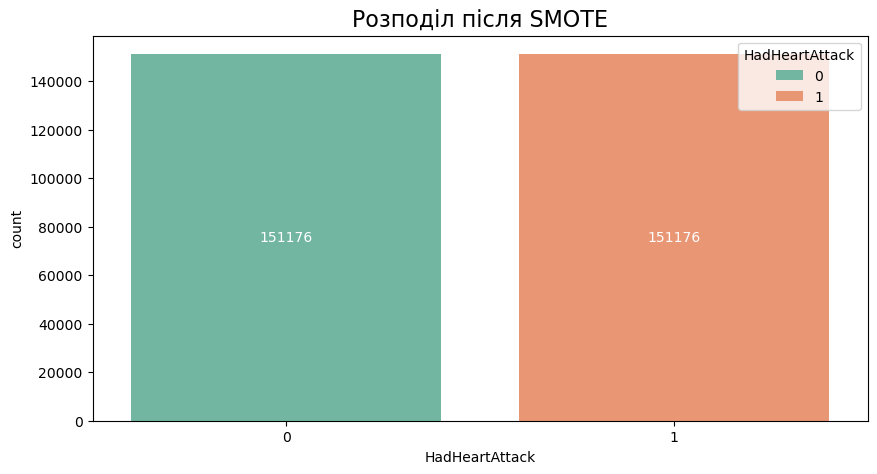

In [98]:
from  imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import threadpoolctl

# Налаштування багатопоточності
with threadpoolctl.threadpool_limits(limits=4, user_api='blas'):
    smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=NearestNeighbors(n_jobs=-1))
    X_smote, y_smote = smote.fit_resample(X_initial_train, y_initial_train)

show_stats(y_smote, "SMOTE")

In [99]:
train_models(X_smote, y_smote, "SMOTE")

           Logistic Regression
Accuracy              0.827827
Precision             0.819684
Recall                0.840389
F1-score              0.829907
AUC                   0.906920
           Decision Tree
Accuracy        0.920670
Precision       0.907741
Recall          0.936454
F1-score        0.921874
AUC             0.920676


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.942793   0.470887  0.394294  0.429200  0.885052
Random_Oversampling  0.805756   0.188352  0.773898  0.302967  0.873873
SMOTE                0.804710   0.163193  0.625080  0.258815  0.802094

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.913121   0.248464  0.292740  0.268791  0.620827
Random_Oversampling  0.907163   0.235605  0.312753  0.268752  0.627105
SMOTE                0.876156   0.184586  0.371727  0.246680  0.638493


### ADASYN

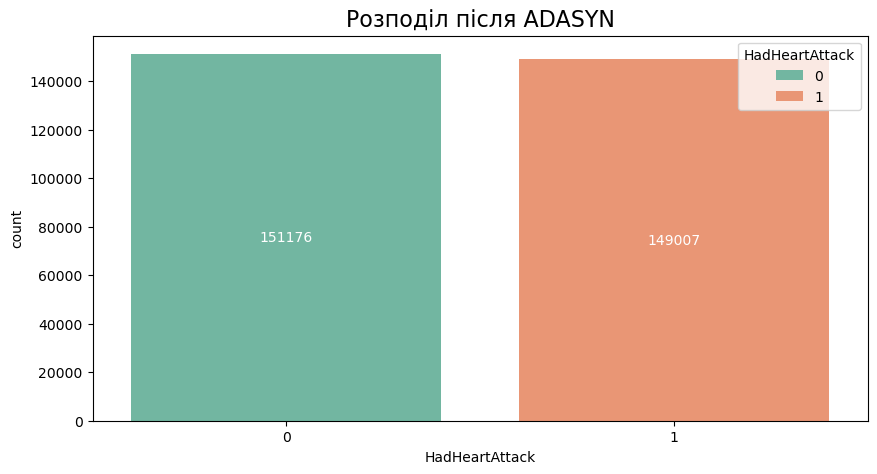

In [100]:
from  imblearn.over_sampling import ADASYN 

adasyn  = ADASYN(n_neighbors=NearestNeighbors(n_jobs=-1), random_state=0)
X_adasyn, y_adasyn = adasyn.fit_resample(X_initial_train, y_initial_train)


show_stats(y_adasyn, "ADASYN")

In [101]:
train_models(X_adasyn, y_adasyn, "ADASYN")

           Logistic Regression
Accuracy              0.824842
Precision             0.815093
Recall                0.837050
F1-score              0.825925
AUC                   0.904108
           Decision Tree
Accuracy        0.920944
Precision       0.905765
Recall          0.938378
F1-score        0.921783
AUC             0.921068


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.942793   0.470887  0.394294  0.429200  0.885052
Random_Oversampling  0.805756   0.188352  0.773898  0.302967  0.873873
SMOTE                0.804710   0.163193  0.625080  0.258815  0.802094
ADASYN               0.801319   0.159842  0.620822  0.254228  0.798286

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.913121   0.248464  0.292740  0.268791  0.620827
Random_Oversampling  0.907163   0.235605  0.312753  0.268752  0.627105
SMOTE                0.876156 

### K-means SMOTE

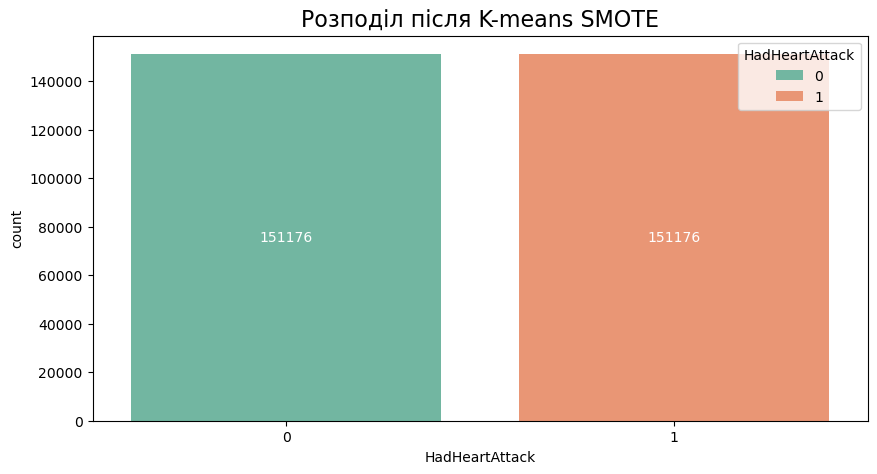

In [102]:
from  imblearn.over_sampling import KMeansSMOTE

KSMOTE  = KMeansSMOTE(cluster_balance_threshold=0.1)
X_KSMOTE, y_KSMOTE = KSMOTE.fit_resample(X_initial_train, y_initial_train)


show_stats(y_KSMOTE, "K-means SMOTE")

In [103]:
train_models(X_KSMOTE, y_KSMOTE, "K-means SMOTE")

           Logistic Regression
Accuracy              0.927247
Precision             0.913210
Recall                0.944168
F1-score              0.928431
AUC                   0.973048
           Decision Tree
Accuracy        0.951193
Precision       0.944492
Recall          0.958689
F1-score        0.951537
AUC             0.951195


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.942793   0.470887  0.394294  0.429200  0.885052
Random_Oversampling  0.805756   0.188352  0.773898  0.302967  0.873873
SMOTE                0.804710   0.163193  0.625080  0.258815  0.802094
ADASYN               0.801319   0.159842  0.620822  0.254228  0.798286
K-means SMOTE        0.880789   0.205895  0.414946  0.275224  0.812370

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.913121   0.248464  0.292740  0.268791  0.620827
Random_Oversampling  0.907163 

### Border SMOTE

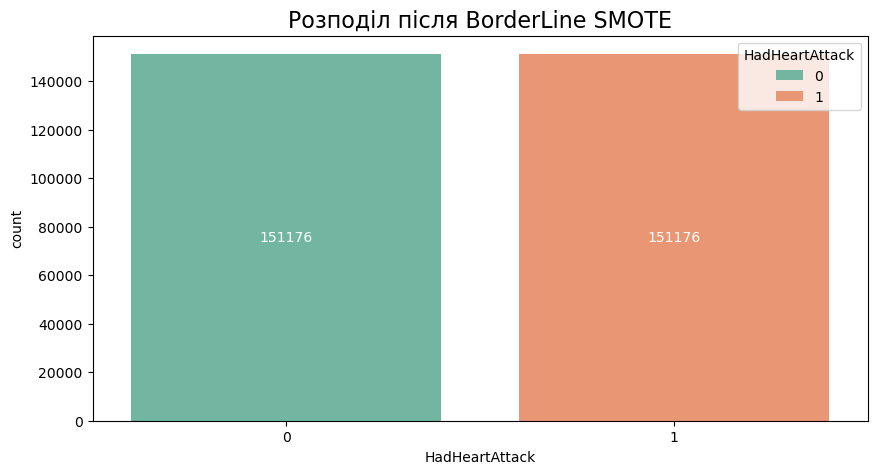

In [104]:
from imblearn.over_sampling import BorderlineSMOTE


borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=0)
X_BSMOTE, y_BSMOTE = borderline_smote.fit_resample(X_initial_train, y_initial_train)

show_stats(y_BSMOTE, "BorderLine SMOTE")

In [105]:
train_models(X_BSMOTE, y_BSMOTE, "BorderLine SMOTE")

           Logistic Regression
Accuracy              0.856110
Precision             0.840752
Recall                0.878505
F1-score              0.859214
AUC                   0.930372
           Decision Tree
Accuracy        0.928948
Precision       0.915069
Recall          0.945605
F1-score        0.930086
AUC             0.928955


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.942793   0.470887  0.394294  0.429200  0.885052
Random_Oversampling  0.805756   0.188352  0.773898  0.302967  0.873873
SMOTE                0.804710   0.163193  0.625080  0.258815  0.802094
ADASYN               0.801319   0.159842  0.620822  0.254228  0.798286
K-means SMOTE        0.880789   0.205895  0.414946  0.275224  0.812370
BorderLine SMOTE     0.822444   0.178602  0.626570  0.277969  0.820358

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.913121 

### Висновок

З результатів порівняння моделей логістичної регресії та дерева рішень при різних методах балансування даних я можу зробити кілька висновків:
1. Модель дерева рішень погано працює при усіх випробуваних методиках балансування. AUC близько 0.6 для усіх методів показує точність передбачення лиш трохи краще за випадкову. Також, з низького показника Precision (0.2-0.25) можна сказати, що дерево рішень дуже погано передбачає позитивні випадки (серцевий напад). Тобто у 8 з 10 випадках модель передбачить серцевий напад там, де його немає.
2. Логістична регресія краще впоралась з передбаченням, але жоден метод балансування не зміг підвищити початковий AUC. Як і для дерева рішень, усі методи показали дуже низький показник Precision (0.15-0.2). Тобто 8 з 10 передбачень серцевого нападу будуть неккоректними. Хоча можна відмітити різке збільшення Recall для методу Random Oversampling, 77% реальних серцевих нападів було правильно передбачено, але робить він це за рахунок великої кількості неправдивих передбачень серцевих нападів (через що маємо низький Precision).
3. Тестування практично усіх підходів балансування на збалансованих даних дає високу точність. Але, очевидно, це не є показником здібності моделі до узагальнення, так як тестування на початкових даних дає значно гірші результати.

Думаю, неефективність oversampling підходу для балансування класів можна пояснити у даному випадку через велику кількість змінних та великий дизбаланс класів (20 до 1), через що дуже важко створити нові реалістичні записи.

**В результаті жоден з oversampling методів балансування класів не запропонував збільшення точності моделі**.

Витягнути таблицю результатів методів після валідації на початкових даних:

In [18]:
with pd.ExcelWriter('oversampling_comparison.xlsx') as writer:
    all_logreg_logs.transpose().to_excel(writer, sheet_name='LogisticRegression', index=False)
    all_dtree_logs.transpose().to_excel(writer, sheet_name='DecisionTree', index=False)

print("Excel файл успішно створено")

Excel файл успішно створено!
